# Kalman via optimisation


In [807]:
import os
import pandas as pd
import sys
from eks.utils import convert_lp_dlc
from eks.multiview_pca_smoother import ensemble_kalman_smoother_multi_cam
from eks.newton_eks import *
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook as tqdm
from scipy.optimize import *
import scipy as sp

## pupil example data (linear case)

In [808]:
pupil1 = "/Users/clairehe/Documents/GitHub/eks/data/ibl-pupil/5285c561-80da-4563-8694-739da92e5dd0.left.rng=0.csv"
df_pupil = pd.read_csv(pupil1, header=[0,1,2], index_col=0)
df_pupil.head()

scorer    heatmap_mhcrnn_tracker                                      \
bodyparts            pupil_top_r                       pupil_right_r   
coords                         x          y likelihood             x   
0                      53.971542  40.784889   0.996096     63.997185   
1                      53.971542  40.784889   0.996096     63.997185   
2                      53.971542  40.784889   0.996096     63.997185   
3                      54.682766  41.602886   0.994934     64.214340   
4                      54.535515  41.143906   0.999473     64.464943   

scorer                                                                \
bodyparts                       pupil_bottom_r                         
coords             y likelihood              x          y likelihood   
0          50.457775   0.998967      54.795803  61.129665   0.995241   
1          50.457775   0.998967      54.795803  61.129665   0.995241   
2          50.457775   0.998967      54.795803  61.129665   0.995241   
3          50.438499   0.996683      55.169212  61.332661   0.999601   
4          50.506241   0.999723      55.322891  60.785454   0.999518   

scorer                                        
bodyparts pupil_left_r                        
coords               x          y likelihood  
0            42.372387  51.355415   0.996667  
1            42.372387  51.355415   0.996667  
2            42.372387  51.355415   0.996667  
3            43.415447  50.964855   0.998236  
4            44.182907  51.238132   0.999794

In [809]:
%run -i 'scripts/pupil_example.py' --csv-dir 'data/ibl-pupil' --save-dir 'data/misc/pupil-test/' --diameter-s 0.99 --com-s 0.99 

Smoothing matrix: [[0.99 0.   0.  ]
 [0.   0.99 0.  ]
 [0.   0.   0.99]]
filtering...
done filtering
smoothing...
done smoothing
saving smoothed predictions to data/misc/pupil-test/kalman_smoothed_pupil_traces.csv
saving latents to data/misc/pupil-test/kalman_smoothed_latents.csv
see example EKS output at data/misc/pupil-test/example_eks_result.pdf


In [810]:
### Preprocess data

from eks.utils import make_dlc_pandas_index
from eks.ensemble_kalman import ensemble
from eks.pupil_utils import get_pupil_location, get_pupil_diameter
def pupil_process():
    # compute ensemble median
    keys = ['pupil_top_r_x', 'pupil_top_r_y', 'pupil_bottom_r_x', 'pupil_bottom_r_y',
            'pupil_right_r_x', 'pupil_right_r_y', 'pupil_left_r_x', 'pupil_left_r_y']
    ensemble_preds, ensemble_vars, ensemble_stacks, keypoints_mean_dict, keypoints_var_dict, keypoints_stack_dict = ensemble(
        markers_list, keys)

    # ## Set parameters
    # compute center of mass
    pupil_locations = get_pupil_location(keypoints_mean_dict)
    pupil_diameters = get_pupil_diameter(keypoints_mean_dict)
    diameters = []
    for i in range(len(markers_list)):
        keypoints_dict = keypoints_stack_dict[i]
        diameter = get_pupil_diameter(keypoints_dict)
        diameters.append(diameter)

    mean_x_obs = np.mean(pupil_locations[:, 0])
    mean_y_obs = np.mean(pupil_locations[:, 1])
    # make the mean zero
    x_t_obs, y_t_obs = pupil_locations[:, 0] - mean_x_obs, pupil_locations[:, 1] - mean_y_obs

    scaled_ensemble_preds = ensemble_preds.copy()
    scaled_ensemble_stacks = ensemble_stacks.copy()
    # subtract COM means from the ensemble predictions
    for i in range(ensemble_preds.shape[1]):
        if i % 2 == 0:
            scaled_ensemble_preds[:, i] -= mean_x_obs
        else:
            scaled_ensemble_preds[:, i] -= mean_y_obs
    # subtract COM means from all the predictions
    for i in range(ensemble_preds.shape[1]):
        if i % 2 == 0:
            scaled_ensemble_stacks[:, :, i] -= mean_x_obs
        else:
            scaled_ensemble_stacks[:, :, i] -= mean_y_obs
    y = scaled_ensemble_preds
    return y, np.vstack([0,mean_x_obs, mean_y_obs])


In [811]:
a, b, c = np.var(pupil_diameters),np.var(x_t_obs),np.var(y_t_obs)

In [812]:
### Initial states
y, mean_array = pupil_process()
r = 3
T = 2000
mu0 = np.asarray([np.mean(pupil_diameters), 0.0, 0.0])

# diagonal: var
S0 = np.asarray([
    [np.var(pupil_diameters), 0.0, 0.0],
    [0.0, np.var(x_t_obs), 0.0],
    [0.0, 0.0, np.var(y_t_obs)]
])

A = np.asarray([
    [0.99, 0, 0],
    [0, 0.99, 0],
    [0, 0, 0.99]
])
B = np.asarray([[0, 1, 0], [-.5, 0, 1], [0, 1, 0], 
                [.5, 0, 1], [.5, 1, 0], [0, 0, 1], 
                [-.5, 1, 0],[0, 0, 1]])

# state covariance matrix
E = np.asarray([
        [np.var(pupil_diameters) * (1 - (A[0, 0] ** 2)), 0, 0],
        [0, np.var(x_t_obs) * (1 - A[1, 1] ** 2), 0],
        [0, 0, np.var(y_t_obs) * (1 - (A[2, 2] ** 2))]
    ])

D = np.eye(8)

In [813]:
pupil_latent = pd.read_csv("/Users/clairehe/Documents/GitHub/eks/data/misc/pupil-test/kalman_smoothed_latents.csv", header=[0,1], index_col=0)
pupil_latent.head()

scorer ensemble-kalman_tracker                      
latent                diameter      com_x      com_y
0                    19.820629  54.719227  50.747470
1                    19.707099  54.772514  50.759262
2                    19.554894  54.870607  50.772020
3                    19.337871  55.074898  50.760586
4                    19.162826  55.176431  50.757116

In [814]:

def hessian(y, mu0, S0, A, B, invD, invE, f = None, df = None, df2 = None, compressed=False):
    """ Calculates hessian for log p(Q|Y)
        obs : y_t|q_t = f(q_t)+ N(0, D) if linear, f(q) = B*q if not df = f'(q), df2 = f''(q)
        latent : q_t|q_{t-1} = A*q_{t-1}+N(0,E)
        
    Args:
        y: np.ndarray -- Each column is the vector of observations of keypoint
            shape (n_samples, n_keypoints)
        mu0: np.ndarray
            shape (n_latents)
        A: np.ndarray
            shape (n_latents, n_latents)
        B: np.ndarray
            shape (n_keypoints, n_latents)
        invD: np.ndarray
            shape (n_keypoints, n_keypoints)
        invE: np.ndarray
            shape (n_latents, n_latents)
        f: np.ndarray
            shape (n_samples, n_keypoints)
        df: np.ndarray
            shape (n_samples, n_keypoints)
        df2: np.ndarray
            shape (n_samples, n_keypoints)
     """ 
    T = y.shape[0]
    r = mu0.shape[0]
    H = np.zeros(shape=(2*r,2*r))  # Hessian should be a block tridiagonal matrix with T blocks of size r by r but we can store the submatrix of size 2*r by 2*r since Kalman equations are quadratic
    
    if f == None: 
        # linear observation map
        H[:r, :r] =  (B.T @ invD @ B + A.T @ invE @ A + invE)
        H[r:, r:] =  (B.T @ invD @ B + A.T @ invE @ A + invE)
    else:
        H[:r, :r] = (df2.T @ invD @ (f - y)+ df.T @ invD @ df)
        H[r:, r:] = (df2.T @ invD @ (f - y)+ df.T @ invD @ df)
    H[:r, r:] = - A.T @ invE
    H[r:, :r] = -(A.T @ invE).T  
    if compressed == True:
        print("Compressed central 2*r by 2*r blocks")
        return H
    else :
        bigH = np.zeros((T, T))
        for i in range(T//r -1):
            bigH[r*i:r*(i+1), r*i:r*(i+1)] = H[:r,:r] # diagonal 
            bigH[r*(i+1):r*(i+2), r*i:r*(i+1)] = H[:r,r:2*r] # superdiagonal
            bigH[r*i:r*(i+1), r*(i+1):3*(i+2)] = H[r:2*r,:r] # subdiagonal
        bigH[:r,:r] = np.linalg.inv(S0)+ A.T@invE@A
        bigH[T-2*r:,T-2*r:] = H
        bigH[T-r:,T-r:] = invE + B.T @ invD @ B
        print("Full matrix of size T by T")
        return bigH

In [815]:
q = pupil_latent.to_numpy()

In [816]:
    
def kalman_newton_recursive(y, mu0, S0, A, B, D, E, f = None, df = None,df2 = None):
    """
    One-pass Kalman recursive method described in J. Humphrey et J. West, "Kalman filtering with Newton's method" 
    https://math.byu.edu/~jeffh/publications/papers/HW.pdf 
    
    
    """
    r = mu0.shape[0]
    T = y.shape[0]
    
    invE = np.linalg.inv(E)
    invD = np.linalg.inv(D)
    grad_z = dict.fromkeys(range(0, T))
    q = np.zeros((T,r))
    q[0,:] = mu0


    if f == None:
        print("Linear solve...")
        
        # H = hessian(y, mu0, A, B, invD, invE, compressed=True),r,r
        P = np.linalg.inv(S0) 
        for t in tqdm.tqdm(range(1,T-1)):
           # idea is to define z[t,:] = np.vstack([z[t-1,:], A@q[t-1,:]]) 
           # so grad_z[t] = np.vstack([0, B.T@invD@(B@A@q[t,:]-y[t,:])])
           # Newton step : z = z - (Hessian)^{-1} grad_z 
           # where hessian is block tridiagonal 
           # can be simplified using Schur, Woodbury and tridiagonal 
           # structure to the following updates
            q[t,:] = A@q[t-1,:]-P@B.T@invD@(B@A@q[t-1,:]-y[t,:])   

            P = np.linalg.inv(np.linalg.inv(E+A@P@A.T)+B.T@D@B)
            
        q[T-1,:] = A@q[T-2,:]-P@B.T@invD@(B@A@q[T-2,:]-y[T-1,:])  
    #else: 
        # to be done, gradient is less straightforward
    return q
    


In [817]:
q_test =kalman_newton_recursive(y, mu0, S0, A, B, D, E, f = None, df = None,df2 = None)

Linear solve...


  0%|          | 0/1998 [00:00<?, ?it/s]

In [818]:
q_pred = np.zeros((T,r))
for i in range(r):
    q_pred[:,i] = q_test[:,i]+mean_array[i]

In [819]:
def get_likelihood(y, q, mu0, S0, A, B, D, E):
    invE = np.linalg.inv(E)
    invD = np.linalg.inv(D)
    loglik = np.zeros(T)
    loglik[0]= (q[:,0]-mu0).T @ np.linalg.inv(S0) @ (q[:,0]-mu0)
    for k in range(1,y.shape[0]):
        loglik[k] = (y[k,:]-B@q[:,k]).T@invD@(y[k,:]-B@q[:,k])
        + (q[:,k]-A@q[:,k-1]).T@invE@(q[:,k]-A@q[:,k-1])+loglik[k-1]
    plt.plot(loglik)
    return loglik
    

In [820]:
#mean_array[0] = mu0[0]

In [821]:
q_norm = np.zeros((T,r))
for i in range(r):
    q_norm[:,i] = q[:,i]-mean_array[i]
q_norm[:,0]=q[:,0]- mu0[0]
q_test[:,0]=q_test[:,0]- mu0[0]

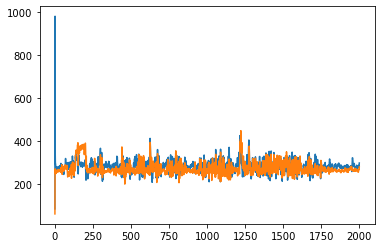

In [822]:
log1 = get_likelihood(y,q_test.T, mu0, S0, A, B, D, E)
log0 =  get_likelihood(y,q_norm.T, mu0, S0, A, B, D, E)

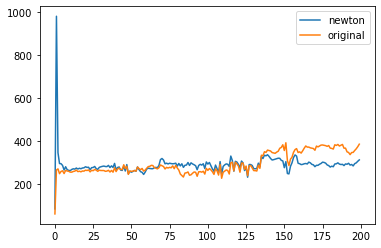

In [823]:
plt.plot(log1[:200], label="newton")
plt.plot(log0[:200],label="original")
plt.legend()

In [824]:
np.sum(log1-log0>0)/2000

0.7225

In [825]:
def gradient2(q, y, mu0, S0, A, B, invD, invE):
    T = y.shape[0]
    G = np.zeros((T,r))
    G[0,:] = A.T @ invE @(q[1,:] - A @ q[0,:])+np.linalg.inv(S0)@(q[0,:]-mu0)+B.T@invD@(y[0,:]-B@q[0,:])
    #A.T @ invE @(q[1,:] - A @ q[0,:]) +np.linalg.inv(S0)@(q[0,:]-mu0)+B.T@invD@(y[0,:]-B@q[0,:])
    for t in range(1,T-1):
        G[t,:] = (A.T @ invE @ A - invE + B.T @ invD @ B)@ q[t,:] - invE.T @A @ q[t-1,:] - A.T @ invE @ q[t+1,:] - B.T @ D @y[t,:] 
    G[T-1,:] = (A.T @ invE @ A - invE + B.T @ invD @ B)@ q[t,:] - invE.T @A @ q[t-1,:]  - B.T @ D @y[t,:] 
    return G

In [826]:
invE = np.linalg.inv(E)
invD = np.linalg.inv(D)

In [827]:
G_pred = gradient2(q_test, y, mu0, S0, A, B, invD, invE)
G_o = gradient2(q_norm, y, mu0, S0, A, B, invD, invE)

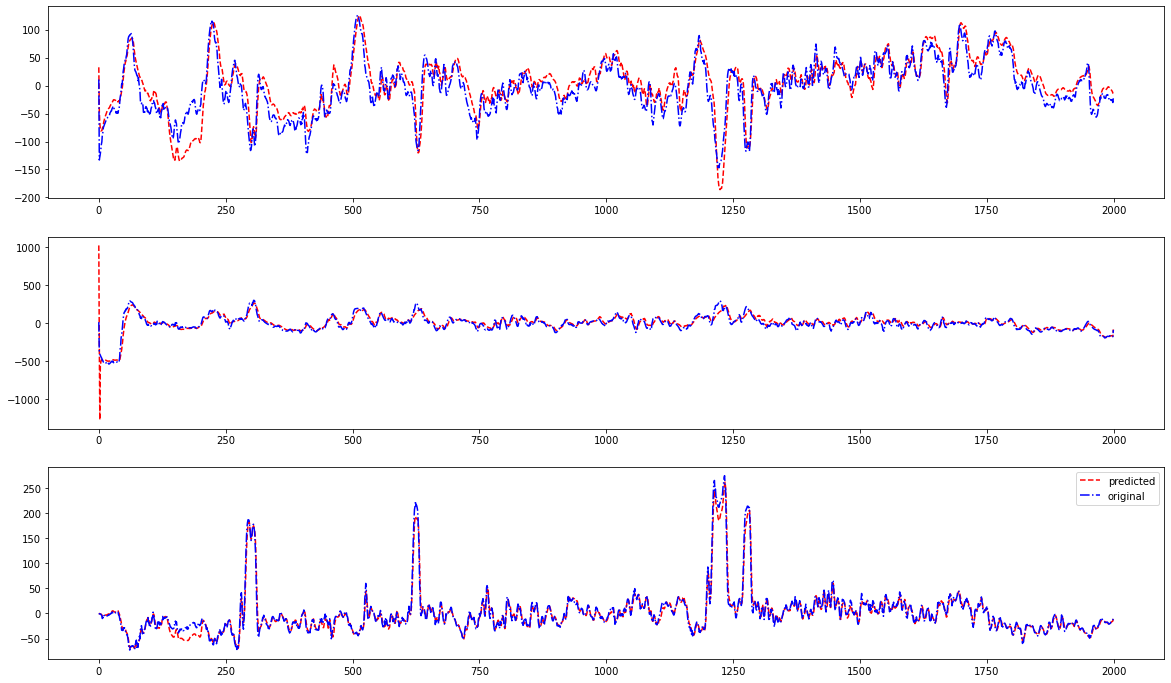

In [828]:
fig, ax = plt.subplots(3,1,figsize=(20,12))
for i in range(3):
    ax[i].plot(G_pred[:,i], "r--", label='predicted')
    ax[i].plot(G_o[:,i], "b-.", label='original')
plt.legend()

In [829]:
No = np.linalg.norm(G_o,axis=0)
Npred = np.linalg.norm(G_pred,axis=0)

In [830]:
Npred, No

(array([2135.08955029, 4840.14102613, 1981.24782383]),
 array([2051.00094363, 4899.03012068, 2072.69182802]))

In [831]:
Npred-No

array([ 84.08860665, -58.88909455, -91.44400419])

In [832]:
H = hessian(y, mu0, S0, A, B, invD, invE, compressed=False)
minimum = G_o.T @ np.linalg.inv(H) @ G_o

Full matrix of size T by T


In [833]:
minimum

array([[1497766.97522559,  974478.95545791, -362031.27432008],
       [ 974478.95545791, 8795548.86801034, 1169356.20984438],
       [-362031.27432008, 1169356.20984438, 1376650.3649271 ]])

In [834]:
Nabla = np.zeros((r,T))
Nabla @ np.linalg.inv(H) @ Nabla.T

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

Banded storage form: solveh_banded uses Thomas algorithm.
ab[u + i - j, j] == a[i,j] (if upper form; i <= j) ab[ i - j, j] == a[i,j] (if lower form; i >= j)
u number of upper diagonals.
 

In [836]:
def convert_to_banded(H):
    n = H.shape[0]
    diagonals = [H.diagonal(offset=i) for i in range(H.shape[1])]
    d = [d for d in diagonals if np.any(d)]
    print(d)
    v = [np.zeros(n-len(elem)) for elem in d]
    
    AB = np.array([np.hstack([d[i],v[i]]) for i in range(len(d))])
    return AB
#convert_to_banded(H)

In [837]:
newton_eks_linear(y, mu0, S0, A, B, D, E)

Full matrix of size T by T
[array([16.35733597, 65.62522375, 11.07912358, ..., 17.35733597,
       69.62522375, 15.07912358]), array([-16.19376261, -64.96897151, -10.96833235, ..., -16.19376261,
       -64.96897151, -10.96833235])]


LinAlgError: 1th leading minor not positive definite

In [855]:
def newton_eks_linear(y, mu0, S0, A, B, D, E, mode="banded"):
    r = mu0.shape[0]
    T = y.shape[0]
    invD = np.linalg.inv(D)
    invE = np.linalg.inv(E)
    
    H = hessian(y, mu0, S0, A, B, invD, invE, compressed=False)
    q = np.zeros((T,r))
    G = gradient2(q, y, mu0, S0, A, B, invD, invE)
    if mode=="banded":
        ab = convert_to_banded(H)
        for i in range(r):
            q[:,i] = - sp.linalg.solveh_banded(ab, G[:,i])
    elif mode=="linalg.inv":
        q = - np.linalg.inv(H)@G
    elif mode=="recursive":
        q = kalman_newton_recursive(y, mu0, S0, A, B, D, E, f = None, df = None,df2 = None)
    elif mode=="linalg.solve":
        for i in range(r):
            q[:,i] = - np.linalg.solve(H,G[:,i])
    return q

In [856]:
q_1 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="linalg.inv")
q_2 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="recursive")
q_4 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="linalg.solve")
q_3 = newton_eks_linear(y, mu0, S0, A, B, D, E, mode="linalg.banded")

Full matrix of size T by T
Full matrix of size T by T
Linear solve...


  0%|          | 0/1998 [00:00<?, ?it/s]

Full matrix of size T by T
Full matrix of size T by T


In [868]:
def latent_plots(q_test, q, n=2000, **words):
    fig, ax = plt.subplots(3,1,figsize=(20,12))
    _, mean_array = pupil_process()
    for i in range(3):
        ax[i].plot(q[:n,i], "-.",color="grey", label="standard eks")
        ax[i].plot(q_test[:,i]+mean_array[i], "--",color="green", label="newton eks")
    plt.legend()
    plt.suptitle("Kalman eks vs optimisation based latent predictions on pupil data")


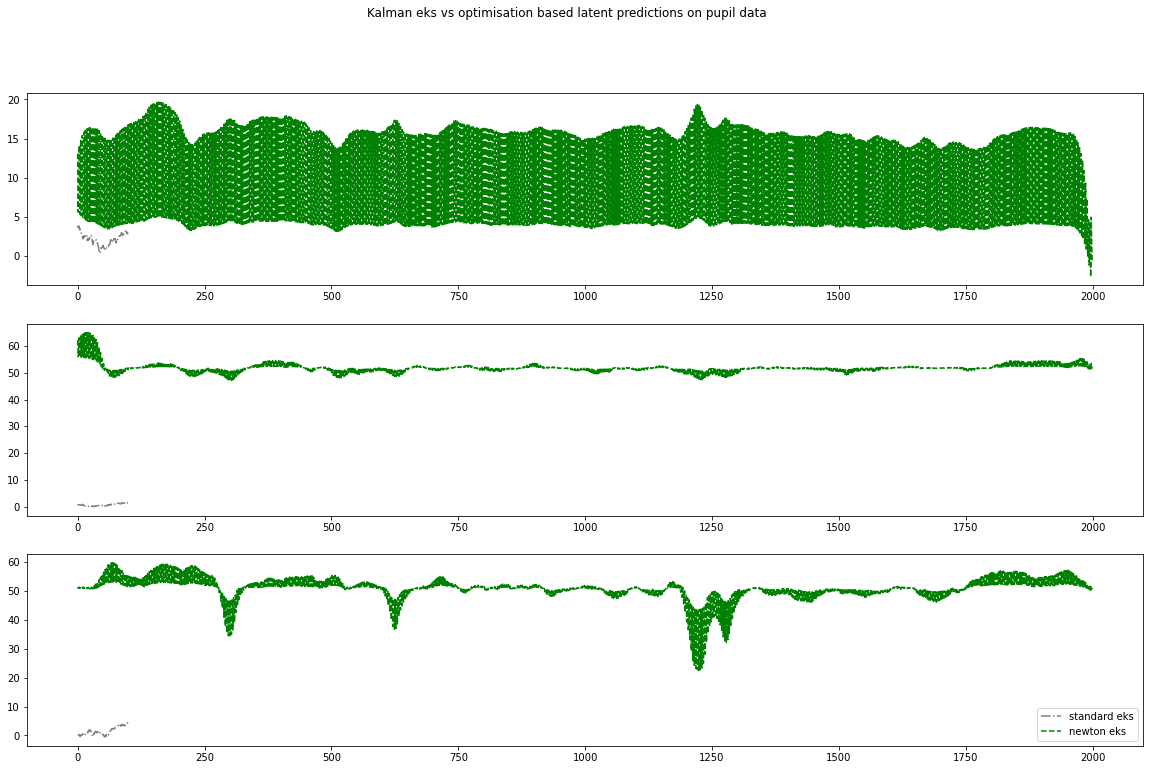

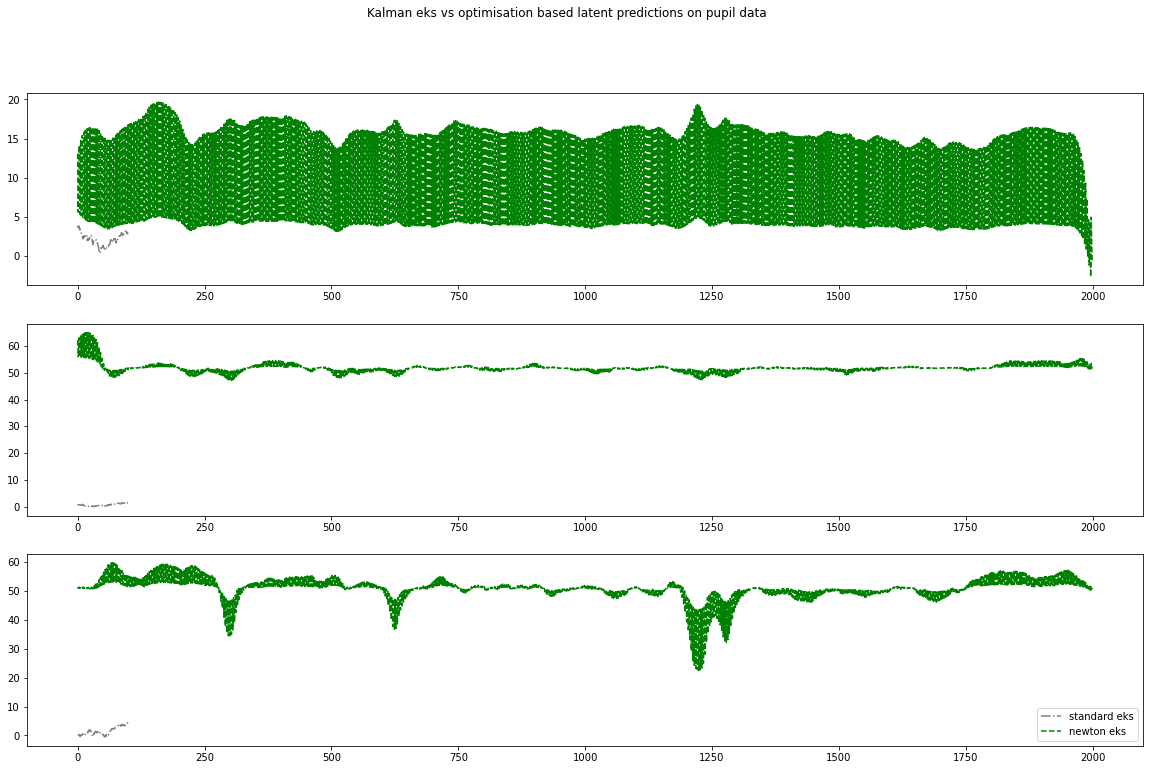

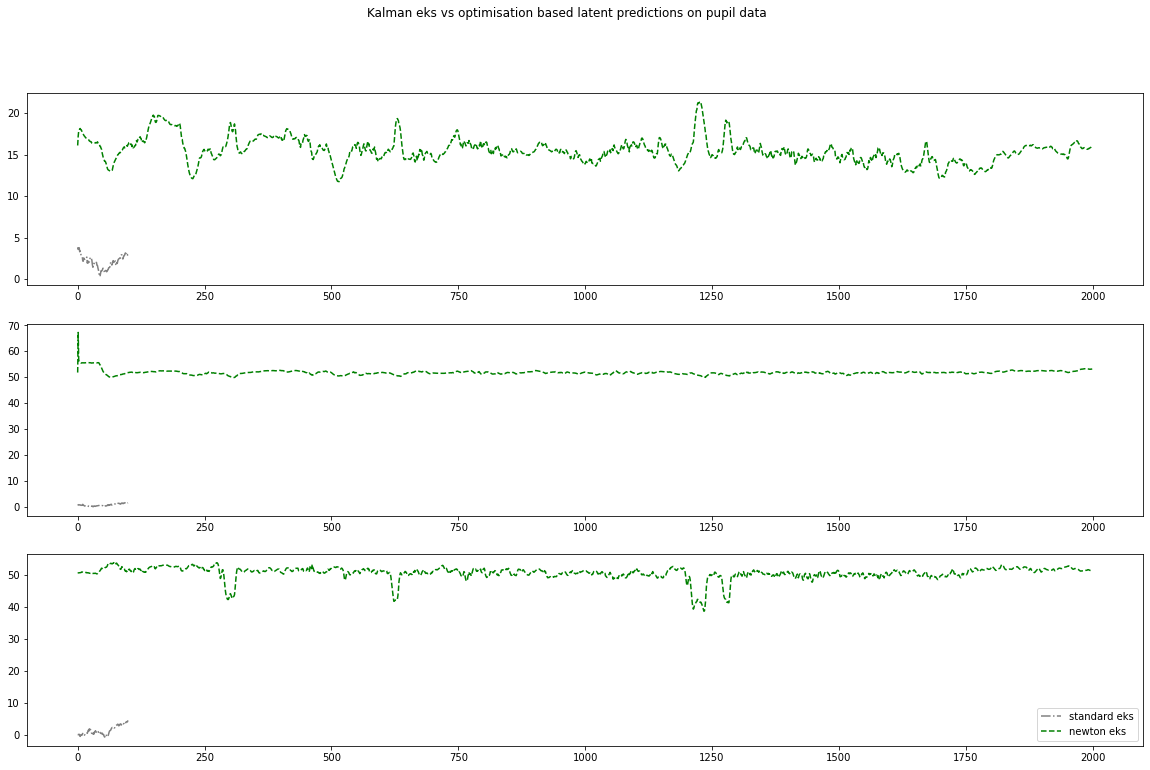

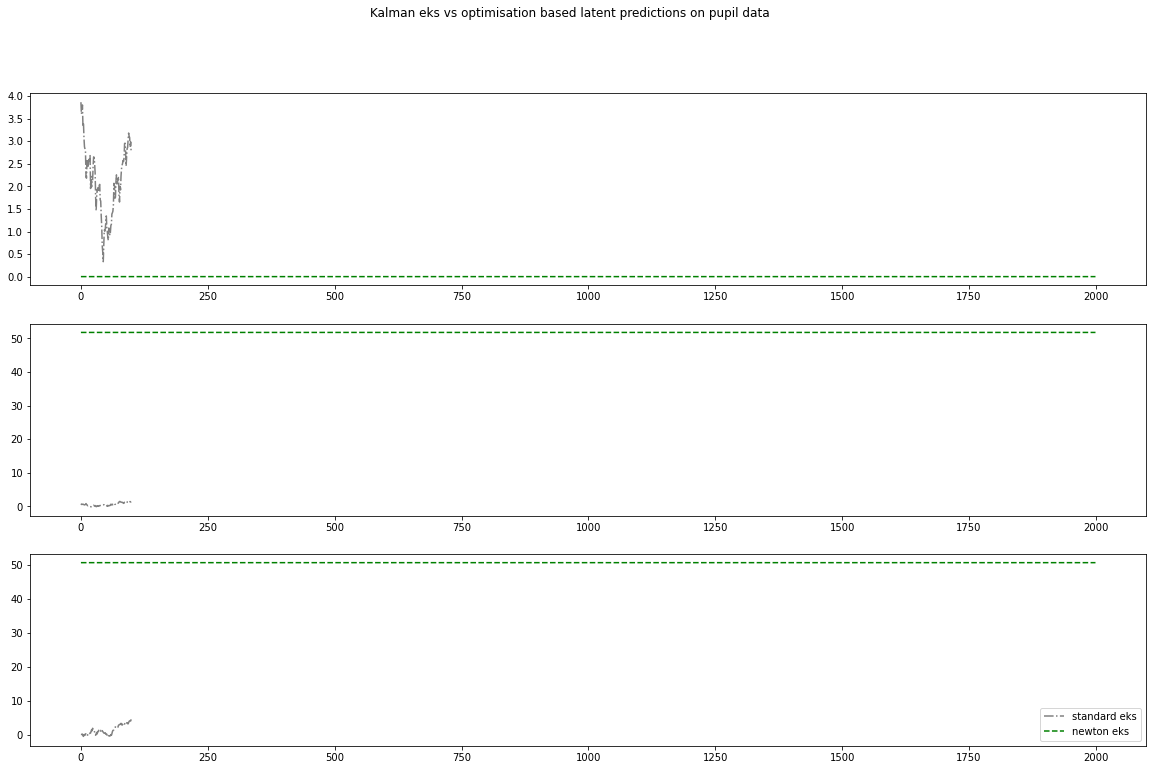

In [869]:
n=2000
latent_plots(q_4[:n,:],q, n)
latent_plots(q_1[:n,:],q, n)
latent_plots(q_2[:n,:],q, n)
latent_plots(q_3[:n,:],q, n)

In [859]:
q_3[:,1].shape

(2000,)

In [403]:
mean_array

array([[16.11796849],
       [51.77925537],
       [50.72478292]])

# Simulations

In [884]:
np.random.seed(88)
n = 8
r = 3
T = 100

mu0 = np.asarray([0.0, 0.0, 0.0])

# diagonal: var
S0 = np.asarray([
    [a, 0.0, 0.0],
    [0.0, b, 0.0],
    [0.0, 0.0, c]
])

A = np.asarray([
    [0.99, 0, 0],
    [0, 0.99, 0],
    [0, 0, 0.99]
])
B = np.asarray([[0, 1, 0], [-.5, 0, 1], [0, 1, 0], 
                [.5, 0, 1], [.5, 1, 0], [0, 0, 1], 
                [-.5, 1, 0],[0, 0, 1]])

# state covariance matrix
E = np.asarray([
        [a * (1 - (A[0, 0] ** 2)), 0, 0],
        [0, b * (1 - A[1, 1] ** 2), 0],
        [0, 0, c * (1 - (A[2, 2] ** 2))]
    ])

D = np.eye(8)

q = np.zeros((T,r))
y = np.zeros((T,n))
q[0,:] = np.random.multivariate_normal(mu0, S0)
y[0,:] = np.random.multivariate_normal(B@q[0,:], D)
for i in range(1,T):
    q[i,:] = np.random.multivariate_normal(A@q[i-1,:], E)
    y[i,:] = np.random.multivariate_normal(B@q[i,:], D)


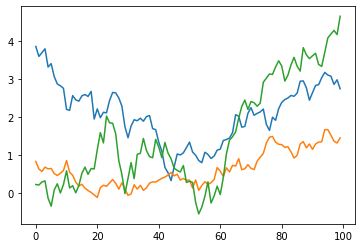

In [885]:
for i in range(r):
    plt.plot(q[:,i])

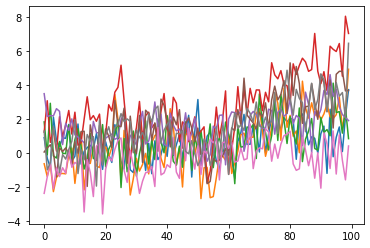

In [886]:
for i in range(n):
    plt.plot(y[:,i])

In [887]:
q1 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="linalg.solve")
q2 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="linalg.inv")
q4 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="recursive")
q3 =newton_eks_linear(y, mu0, S0, A,B,D,E, mode="banded")

Full matrix of size T by T
Full matrix of size T by T
Full matrix of size T by T
Linear solve...


  0%|          | 0/98 [00:00<?, ?it/s]

Full matrix of size T by T
[array([ 16.35733597,  65.62522375,  11.07912358,  33.38916095,
       133.94450555,  25.93777261,  33.38916095, 133.94450555,
        25.93777261,  33.38916095, 133.94450555,  25.93777261,
        33.38916095, 133.94450555,  25.93777261,  33.38916095,
       133.94450555,  25.93777261,  33.38916095, 133.94450555,
        25.93777261,  33.38916095, 133.94450555,  25.93777261,
        33.38916095, 133.94450555,  25.93777261,  33.38916095,
       133.94450555,  25.93777261,  33.38916095, 133.94450555,
        25.93777261,  33.38916095, 133.94450555,  25.93777261,
        33.38916095, 133.94450555,  25.93777261,  33.38916095,
       133.94450555,  25.93777261,  33.38916095, 133.94450555,
        25.93777261,  33.38916095, 133.94450555,  25.93777261,
        33.38916095, 133.94450555,  25.93777261,  33.38916095,
       133.94450555,  25.93777261,  33.38916095, 133.94450555,
        25.93777261,  33.38916095, 133.94450555,  25.93777261,
        33.38916095, 133.94

LinAlgError: 1th leading minor not positive definite

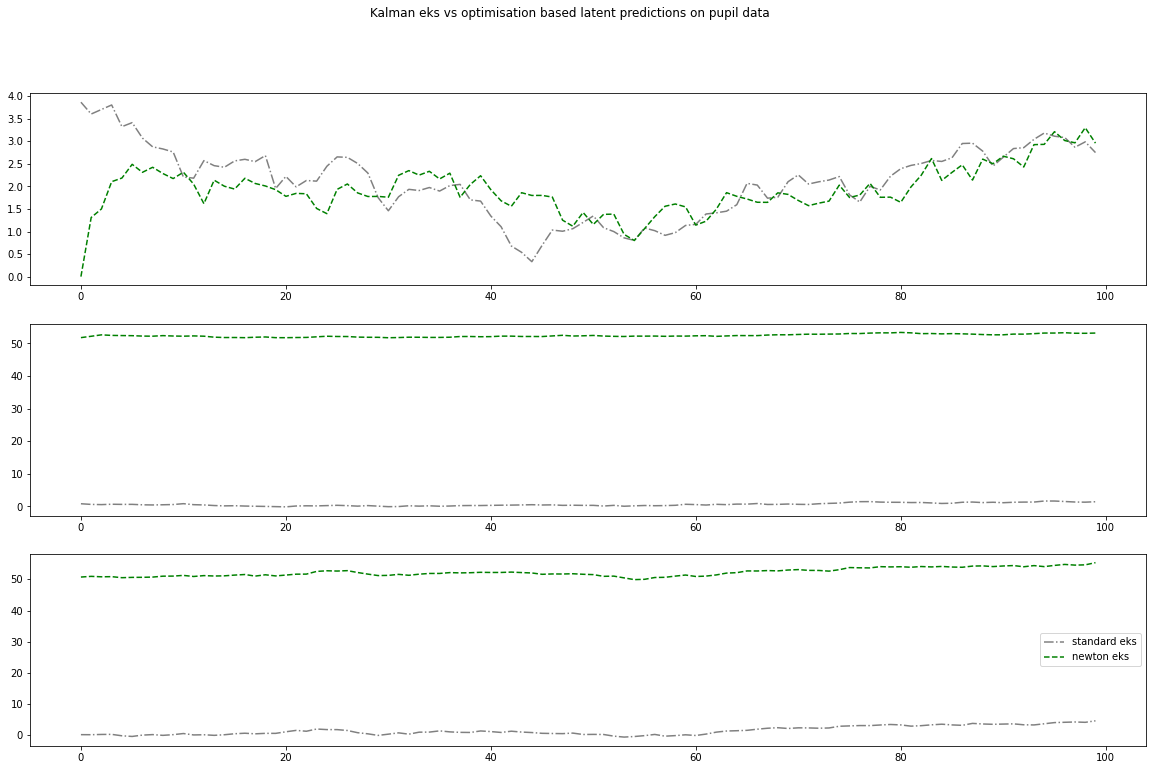

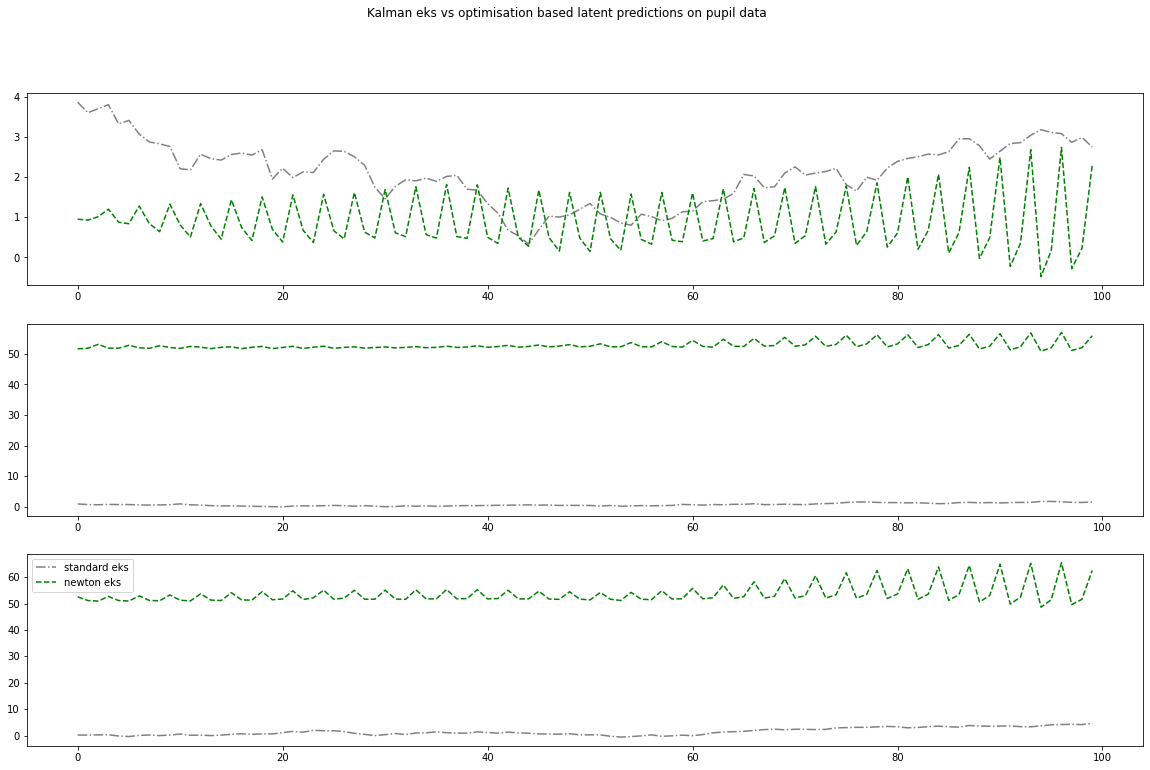

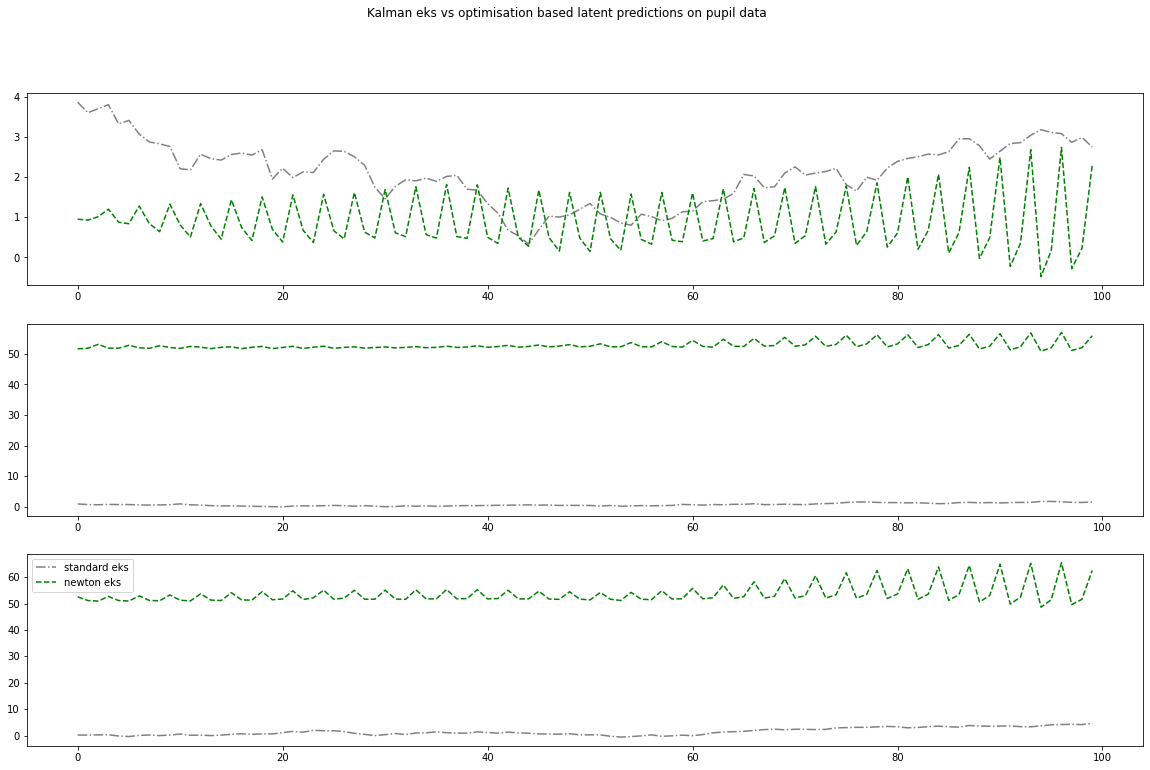

In [888]:
n=100
latent_plots(q4[:n,:], q,n)
latent_plots(q1[:n,:], q,n)
latent_plots(q2[:n,:], q,n)
#latent_plots(q3[:n,:], q,n)